In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_1 import *

Pytorch utils oh: pytorch_utils_oh_1.py
Pytorch: 0.2.0_4


In [27]:
MODEL_SAVE_PATH = 'category_1_mod_data_common_words'

In [345]:
import pytorch_utils_oh_1; importlib.reload(pytorch_utils_oh_1); from pytorch_utils_oh_1 import *;

Pytorch utils oh: pytorch_utils_oh_1.py
Pytorch: 0.2.0_4


# Data loading

In [230]:
all_data = pickle.load(open("data/en_train_not_changed_1.pkl", "rb" ))
change data
all_data_sentence_index = all_data.set_index('sentence_id')

In [4]:
all_data.sample(5)

,sentence_id,token_id,class,before,after
7459959,565730,6,NOT_CHANGED,",",","
4751479,363745,3,NOT_CHANGED,Hispanic,Hispanic
2165066,168526,16,NOT_CHANGED,.,.
6848805,520203,1,NOT_CHANGED,applications,applications
5290088,404069,4,NOT_CHANGED,Cup,Cup


In [5]:
categories_all = all_data["class"].unique()
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['NOT_CHANGED' 'NUMBERS' 'LETTERS' 'PLAIN' 'VERBATIM' 'ELECTRONIC']
6


### Letters all

In [9]:
tmp = sorted(list(set(''.join(all_data['before']))))
characters_all = ['<EOS>', '<SOS>'] + sorted(list(set(tmp)))
characters_all_index = dict((c, i) for i, c in enumerate(characters_all))
print(''.join(characters_all))
print(len(characters_all))

<EOS><SOS> !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞☒
115


### Common words

In [10]:
common_words = pickle.load(open("data/en_train_words_before_over_100.pk", "rb" ))
common_words = [EOS_TOKEN, SOS_TOKEN, UNKNOWN_WORD_TOKEN, NUMBER_WORD_TOKEN] + common_words
common_words_index = dict((c, i) for i, c in enumerate(common_words))
len(common_words)

7380

**SHOULD HAVE INCLUDED SAMPLE_WORDS_TOKEN ALSO IN HERE, ORIGINALLY WAS NOT HERE**

In [346]:
common_words, common_words_index = load_common_words_100()
len(common_words)

7381

### More balanced sample

In [6]:
all_data.groupby("class")["class"].count()

class
ELECTRONIC        4964
LETTERS         144364
NOT_CHANGED    9218584
NUMBERS         448151
PLAIN            36472
VERBATIM         65855
Name: class, dtype: int64

In [254]:
balanced_data_classes_select = list(all_data.groupby('class'))
balanced_data_accessed_counter = 0 
balanced_data_length = 0
def balanced_data_randomize(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_accessed_counter = 0

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    balanced_data_accessed_counter += 1
    if balanced_data_accessed_counter/balanced_data_length > 0.2:
        balanced_data_randomize()
    return balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    
balanced_data_randomize()

In [224]:
balanced_data.groupby("class")["class"].count()

class
ELECTRONIC      4964
LETTERS        20000
NOT_CHANGED    20000
NUMBERS        20000
PLAIN          20000
VERBATIM       20000
Name: class, dtype: int64

### Samples

In [226]:
def get_random_sample():
    sample_row = balanced_data_sample_row()
    sentence_id = sample_row['class']

    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = list(rows.before)
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = SAMPLE_WORD_TOKEN
    
    return sample_row['before'], sample_row['after'], sample_row['class'], befores
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_class, ':', s_bef, '->', s_aft)
    print(' '.join(s_sentence))
    print(s_sentence)
    print(words_to_tensor(list(s_sentence), common_words_index).shape)
    print(string_to_tensor(s_bef, characters_all_index).shape)
tmp()

ELECTRONIC : Catholic-Hierarchy.org -> c a t h o l i c d a s h h i e r a r c h y dot o r g
" Bishop Giuseppe Pamphilj ( Panfili ) , O.S.A. " <SAMPLE> .
['"', 'Bishop', 'Giuseppe', 'Pamphilj', '(', 'Panfili', ')', ',', 'O.S.A.', '"', '<SAMPLE>', '.']
torch.Size([1, 13, 7380])
torch.Size([1, 23, 115])


# Model

In [14]:
class CategorizeRNN(nn.Module):
    def __init__(self, output_size, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(CategorizeRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
        self.lin_output = nn.Linear(words_hidden_size+chars_hidden_size, output_size)
        
    def forward(self, words_tensor, string_tensor, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(words_tensor, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        
        #output = self.lin_1(output)
        output = self.lin_output(output)
        output = F.log_softmax(output)
        
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

In [28]:
model = CategorizeRNN(len(categories_all), 
                      words_input_size=len(common_words), chars_input_size=len(characters_all),
                      words_hidden_size=128, chars_hidden_size=128)
model = model.cuda()

model_training = ModelTraining(MODEL_SAVE_PATH, [model])

model

Save path: data/models/category_1_mod_data_common_words


CategorizeRNN (
  (rnn_words): LSTM(7380, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(115, 64, batch_first=True, bidirectional=True)
  (lin_output): Linear (256 -> 6)
)

### Accuracy

In [276]:
def test_model_single_sample(model):
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
    
    words_t = words_to_tensor(list(s_sentence), common_words_index)
    words_t = Variable(words_t).cuda()
    
    string_t = string_to_tensor(s_bef, characters_all_index)
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    guess = category_from_output(output, categories_all)

    return output, guess, (s_class, categories_index[s_class]), sample
    
tmp = test_model_single_sample(model)
tmp

(Variable containing:
 -16.8749 -17.4538 -16.0480 -20.1028   0.0000 -18.1157
 [torch.cuda.FloatTensor of size 1x6 (GPU 0)],
 ('VERBATIM', 4),
 ('VERBATIM', 4),
 ('&',
  'and',
  'VERBATIM',
  ['Atlantic', 'Publishers', '<SAMPLE>', 'Distri', '.']))

In [277]:
%%time
test_model_accuracy(model, test_model_single_sample)

Accuracy: 99.28% (    9928/   10000)
CPU times: user 1min 34s, sys: 516 ms, total: 1min 35s
Wall time: 23.9 s


0.9928

### Training

In [25]:
def train(model, s_category, s_sentence, s_bef, loss_function, optimizer):
    
    category_tensor = Variable(torch.LongTensor([categories_index[s_category]])).cuda()
    
    words_t = words_to_tensor(list(s_sentence), common_words_index)
    words_t = Variable(words_t).cuda()
    
    string_t = string_to_tensor(s_bef, characters_all_index)
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [30]:
def train_iterations(n_iters=100000, lr=0.001, print_every=10000, plot_every=1000):

    start = time.time()
    model.train()

    current_loss = 0
    current_loss_iter = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(model=model, s_category=s_class, s_sentence=s_sentence,
                             s_bef=s_bef, optimizer=optimizer, loss_function=loss_function)

        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(result, categories_all)
            correct = '✓' if guess == s_class else "✗ {}".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({})".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, guess, correct))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 10000 == 0 or model_training.iterations == 10:
            balanced_data_randomize()
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(model, test_model_single_sample)
            model.train()
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [31]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

Saved model to data/models/category_1_mod_data_common_words/10_(CategorizeRNN)
Accuracy: 22.57% (    2257/   10000)
    18  18% (  0m 24s)   1.816   |   1.85: ☒ -> NOT_CHANGED (✗ VERBATIM)
    27  36% (  0m 24s)   1.800   |   1.77: SPE -> NOT_CHANGED (✗ LETTERS)
    36  54% (  0m 24s)   1.787   |   1.78: - -> NOT_CHANGED (✗ PLAIN)
    45  72% (  0m 24s)   1.788   |   1.72: crystalline -> NOT_CHANGED (✓)
    54  90% (  0m 24s)   1.787   |   1.77: UDA -> NOT_CHANGED (✗ LETTERS)


In [32]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   559  53% (   0m 3s)   1.744   |   1.71: DT -> NUMBERS (✗ LETTERS)


In [33]:
train_iterations(n_iters=10000, lr=0.0001, print_every=1000)

  2000  10% (   0m 6s)   1.525   |   1.31: offensive -> NUMBERS (✗ NOT_CHANGED)
  3000  20% (  0m 12s)   1.233   |   1.36: Theatre -> NOT_CHANGED (✗ PLAIN)
  4000  30% (  0m 19s)   1.024   |   0.04: ☒ -> VERBATIM (✓)
  5000  40% (  0m 25s)   0.917   |   0.82: franchise -> PLAIN (✓)
  6000  50% (  0m 31s)   0.852   |   1.41: : -> LETTERS (✗ PLAIN)
  7000  60% (  0m 37s)   0.788   |   1.16: mr -> PLAIN (✓)
  8000  70% (  0m 44s)   0.691   |   0.01: ☒ -> VERBATIM (✓)
  9000  80% (  0m 50s)   0.675   |   0.03: ☒ -> VERBATIM (✓)
 10000  90% (  0m 57s)   0.670   |   0.44: size -> NOT_CHANGED (✓)
 11000 100% (   1m 4s)   0.636   |   1.53: % -> PLAIN (✗ VERBATIM)


In [34]:
train_iterations(n_iters=100000, print_every=10000)

 21000  10% (   1m 6s)   0.274   |   0.00: ☒ -> VERBATIM (✓)
 31000  20% (  2m 11s)   0.174   |   0.00: ☒ -> VERBATIM (✓)
 41000  30% (  3m 18s)   0.107   |   1.05: RD -> LETTERS (✗ PLAIN)
Saved model to data/models/category_1_mod_data_common_words/50000_(CategorizeRNN)
Accuracy: 96.00% (    9600/   10000)
 51000  40% (  4m 50s)   0.114   |   0.00: ☒ -> VERBATIM (✓)
 61000  50% (   6m 1s)   0.111   |   0.00: ☒ -> VERBATIM (✓)
 71000  60% (  7m 20s)   0.093   |   0.00: M. -> LETTERS (✓)
 81000  70% (  8m 37s)   0.102   |   0.01: pp -> VERBATIM (✓)
 91000  80% (  9m 55s)   0.096   |   0.00: 8 November 2003 -> NUMBERS (✓)
Saved model to data/models/category_1_mod_data_common_words/100000_(CategorizeRNN)
Accuracy: 97.70% (    9770/   10000)
101000  90% ( 11m 40s)   0.091   |   0.16: tr -> VERBATIM (✓)
111000 100% ( 12m 58s)   0.073   |   0.00: ☒ -> VERBATIM (✓)


In [35]:
train_iterations(n_iters=100000, print_every=10000)

121000  10% (  1m 16s)   0.074   |   0.04: MD -> LETTERS (✓)
131000  20% (  2m 33s)   0.072   |   0.00: ☒ -> VERBATIM (✓)
141000  30% (  3m 51s)   0.084   |   0.00: (1905) 14 -> NUMBERS (✓)
Saved model to data/models/category_1_mod_data_common_words/150000_(CategorizeRNN)
Accuracy: 97.96% (    9796/   10000)
151000  40% (  5m 35s)   0.062   |   0.00: 16 June 1971 -> NUMBERS (✓)
161000  50% (  6m 53s)   0.071   |   0.00: May 1996 -> NUMBERS (✓)
171000  60% (  8m 12s)   0.059   |   0.00: st -> PLAIN (✓)
181000  70% (  9m 29s)   0.085   |   0.00: 1942 -> NUMBERS (✓)
191000  80% ( 10m 46s)   0.061   |   0.00: 1962 -> NUMBERS (✓)
Saved model to data/models/category_1_mod_data_common_words/200000_(CategorizeRNN)
Accuracy: 98.46% (    9846/   10000)
201000  90% ( 12m 30s)   0.059   |   0.00: & -> VERBATIM (✓)
211000 100% ( 13m 47s)   0.056   |   3.62: Yuki -> LETTERS (✗ NOT_CHANGED)


In [42]:
train_iterations(n_iters=300000, lr=0.0001, print_every=25000)

236000   8% (  3m 43s)   0.057   |   0.00: 44 -> NUMBERS (✓)
Saved model to data/models/category_1_mod_data_common_words/250000_(CategorizeRNN)
Accuracy: 98.69% (    9869/   10000)
261000  17% (   8m 8s)   0.027   |   0.00: KVPY -> LETTERS (✓)
286000  25% ( 11m 57s)   0.040   |   0.00: 2011 -> NUMBERS (✓)
Saved model to data/models/category_1_mod_data_common_words/300000_(CategorizeRNN)
Accuracy: 98.77% (    9877/   10000)
311000  33% ( 15m 51s)   0.057   |   0.00: NZFW -> LETTERS (✓)
336000  42% ( 19m 10s)   0.058   |   0.00: ZQ -> LETTERS (✓)
Saved model to data/models/category_1_mod_data_common_words/350000_(CategorizeRNN)
Accuracy: 98.70% (    9870/   10000)
361000  50% (  23m 0s)   0.030   |   0.00: 2004 -> NUMBERS (✓)
386000  58% ( 26m 22s)   0.023   |   0.00: Theatre -> PLAIN (✓)
Saved model to data/models/category_1_mod_data_common_words/400000_(CategorizeRNN)
Accuracy: 98.68% (    9868/   10000)
411000  67% ( 30m 14s)   0.048   |   0.00: Shirley -> NOT_CHANGED (✓)
436000  75% 

In [264]:
train_iterations(n_iters=200000, print_every=10000)

560000   5% (   1m 3s)   0.059   |   0.02: Ridge -> NOT_CHANGED (✓)
570000  10% (  2m 10s)   0.067   |   0.00: 2010 -> NUMBERS (✓)
580000  15% (  3m 13s)   0.041   |   0.00: first -> NOT_CHANGED (✓)
590000  20% (  4m 15s)   0.031   |   0.00: ☒ -> VERBATIM (✓)
600000  25% (  5m 20s)   0.043   |   0.00: unknown -> NOT_CHANGED (✓)
Saved model to data/models/category_1_mod_data_common_words/600000_(CategorizeRNN)
Accuracy: 98.55% (    9855/   10000)
610000  30% (  6m 49s)   0.029   |   0.00: AFC -> LETTERS (✓)
620000  35% (  7m 54s)   0.039   |   0.01: wings -> NOT_CHANGED (✓)
630000  40% (   9m 0s)   0.041   |   0.00: J.P. -> LETTERS (✓)
640000  45% (  10m 4s)   0.034   |   0.00: ☒ -> VERBATIM (✓)
650000  50% ( 11m 10s)   0.027   |   0.00: ☒ -> VERBATIM (✓)
Saved model to data/models/category_1_mod_data_common_words/650000_(CategorizeRNN)
Accuracy: 98.84% (    9884/   10000)
660000  55% ( 12m 39s)   0.057   |   0.00: September 15, 2015 -> NUMBERS (✓)
670000  60% ( 13m 43s)   0.023   |   0

In [265]:
train_iterations(n_iters=200000, print_every=10000, lr=0.0001)

760000   5% (   1m 4s)   0.025   |   0.00: June 20, 2015 -> NUMBERS (✓)
770000  10% (  2m 11s)   0.053   |   0.00: 3.06 -> NUMBERS (✓)
780000  15% (  3m 16s)   0.036   |   0.00: 4 August 2008 -> NUMBERS (✓)
790000  20% (  4m 22s)   0.035   |   0.00: honours -> PLAIN (✓)
800000  25% (  5m 25s)   0.020   |   0.57: AMc -> LETTERS (✓)
Saved model to data/models/category_1_mod_data_common_words/800000_(CategorizeRNN)
Accuracy: 99.18% (    9918/   10000)
810000  30% (  6m 53s)   0.025   |   0.00: 2015 -> NUMBERS (✓)
820000  35% (  7m 56s)   0.031   |   0.00: 105 -> NUMBERS (✓)
830000  40% (  8m 59s)   0.036   |   0.68: Towa -> LETTERS (✓)
840000  45% (  10m 2s)   0.017   |   0.00: defender -> NOT_CHANGED (✓)
850000  50% (  11m 5s)   0.026   |   0.00: ☒ -> VERBATIM (✓)
Saved model to data/models/category_1_mod_data_common_words/850000_(CategorizeRNN)
Accuracy: 99.10% (    9910/   10000)
860000  55% ( 12m 32s)   0.029   |   0.00: 90s -> NUMBERS (✓)
870000  60% ( 13m 34s)   0.037   |   0.00: ht

# Results

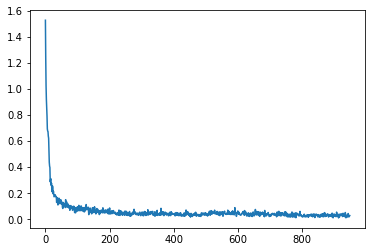

In [266]:
plt.figure()
plt.plot(model_training.losses)

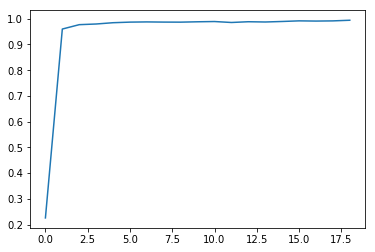

In [267]:
plt.figure()
plt.plot(model_training.accuracy)

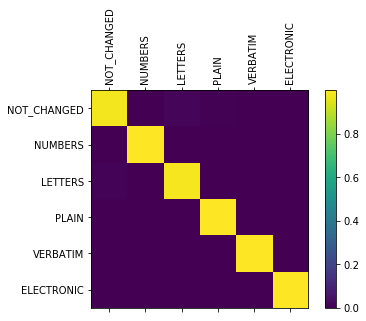

Accuracy: 99.16% (   49582/   50000)
CPU times: user 7min 57s, sys: 2.58 s, total: 7min 59s
Wall time: 2min


In [268]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample, n_confusion=50000)

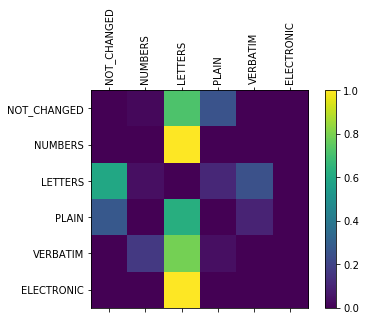

Accuracy: 99.21% (   49605/   50000)
CPU times: user 8min 4s, sys: 2.65 s, total: 8min 7s
Wall time: 2min 2s


In [269]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample,
                               n_confusion=50000, remove_diagonal=True)

In [310]:
tmp = get_some_wrong_predictions(model, test_model_single_sample, max_iterations=10000, max_results=10)
for sample, predict, output in tmp:
    s_bef, s_aft, s_class, s_sentence = sample
    m = torch.nn.functional.softmax(output).max().data[0]
    print("{:>11} -> {:>11} ({:0.3}) || {:>8} -> {} == {}".format(s_class, predict[0], m, s_bef, s_aft, ' '.join(s_sentence), ))

    LETTERS -> NOT_CHANGED (0.558) ||    Baicu -> b a i c u == The <SAMPLE> River or Boicu River is a tributary of the Iza River in Romania .
    LETTERS -> NOT_CHANGED (0.996) ||  srpskih -> s r p s k i h == Oslobodilacki rat <SAMPLE> ustanika , 1804 - 1806 .
NOT_CHANGED ->     LETTERS (0.873) ||      Hai -> Hai == <SAMPLE> Yung ( Chinese : ☒ ☒ ; pinyin : Hairong ) was a protected cruiser of the Chinese Navy .
    LETTERS ->    VERBATIM (0.657) ||      vrb -> v r b == In contemporary times , the largest inhabited settlement is the village of <SAMPLE> jani .
NOT_CHANGED ->       PLAIN (0.933) ||        - -> - == " Pentraxins in innate immunity : from C <SAMPLE> reactive protein to the long pentraxin PTX 3 " .
NOT_CHANGED ->     LETTERS (0.94) ||    LISTA -> LISTA == " SOK I VG- <SAMPLE> OG HIT 40 " .
      PLAIN ->     LETTERS (0.95) ||       BR -> bridge == Mason <SAMPLE> , Page KA , Fallon K ( June 1999 ) .
    LETTERS ->    VERBATIM (0.666) ||       wp -> w p == <SAMPLE> rost ( in P